In [10]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc

<font color=black size=5 face=雅黑>競賽連結及排名</font>

* Janatahack: Cross-sell Prediction
* **成績: 0.83662**
* **排名: 14.5%, 315/21673**
*https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/#About 


<font color=black size=5 face=雅黑>競賽簡介</font>

* 您的客戶是一家為其客戶提供健康保險的保險公司，現在他們需要您幫助建立模型來預測過去一年的保單持有人（客戶）是否也會對公司提供的車輛保險感興趣。
* 建立一個模型來預測客戶是否會對車輛保險感興趣，這 對公司非常有幫助，因為它可以相應地規劃其溝通策略以接觸這些客戶並優化其業務模型和收入。
* 評估指標 ROC_AUC 分數


<font color=black size=5 face=雅黑>競賽總結</font>

**由EDA觀察到以下幾點:**
* 年輕人偏向買新車，會選擇他們喜歡的通路(例如網路)
* 30歲以下，已有車險比例高，相對的購買意願低。
* 年齡成右偏分布，可能是一個新興保險市場。
* 車齡跟通路關係，其實是因為年齡跟通路，間接影響車齡

根據特徵重要性與模型預測結果，
會建議公司在這個區域的業務推動，主力客群建議如下：

* **年齡層30~60**，意願高 (原因是，30歲以下有車險比例高)
* **無車險，並且有曾有車損**的客戶
* 有意願比例最高**前十地區**，Region_Code: 38,28,19,4,23,51,24,7,18,3

後續發展
* 車齡特徵重要性低，但可以知道數據中 車齡>2年 資料很少，但有意願比例卻高達0.294，1~2年意願比例0.174 (因為，年齡低，車齡低，所以意願低，這是有關係的)
* 對"Vintage"特徵做更多工程



<font color=black size=5 face=雅黑>匯入資料</font>

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
train.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


<font color=black size=5 face=雅黑>欄位及缺失值檢查</font>

In [6]:
print('Number of train rows: '+ format(train.shape[0]) +', number of train features: '+ format(train.shape[1]))
print('Number of test rows: '+ format(test.shape[0]) +', number of test features: '+ format(test.shape[1]))

Number of train rows: 381109, number of train features: 12
Number of test rows: 127037, number of test features: 11


In [7]:
Missing_Percentage = (train.isnull().sum()).sum()/np.product(train.shape)*100
print("The number of train missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")
Missing_Percentage = (test.isnull().sum()).sum()/np.product(test.shape)*100
print("The number of test missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

The number of train missing entries before cleaning: 0.0 %
The number of test missing entries before cleaning: 0.0 %


<font color=black size=5 face=雅黑>探索性分析</font>

In [18]:
print('Number of unique elements in each column')
print('******************************************')
for i in train.columns:
  uniq = train[i].nunique()
  print(f'{i}: {uniq}')

Number of unique elements in each column
******************************************
id: 381109
Gender: 2
Age: 66
Driving_License: 2
Region_Code: 53
Previously_Insured: 2
Vehicle_Age: 3
Vehicle_Damage: 2
Annual_Premium: 48838
Policy_Sales_Channel: 155
Vintage: 290
Response: 2


<font color=black size=5 face=雅黑>目標: Response比例</font>

0    334399
1     46710
Name: Response, dtype: int64

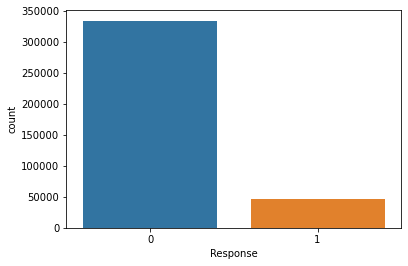

In [12]:
sns.countplot(train.Response)
train['Response'].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

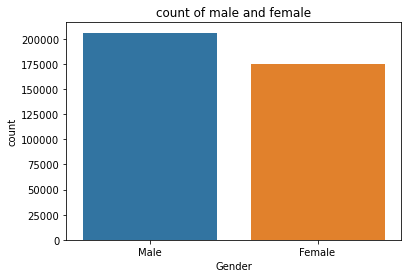

In [10]:
#性別分布，一半一半
sns.countplot(train['Gender'])
plt.title("count of male and female")
train['Gender'].value_counts()

<font color=black size=5 face=雅黑>Age</font>

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

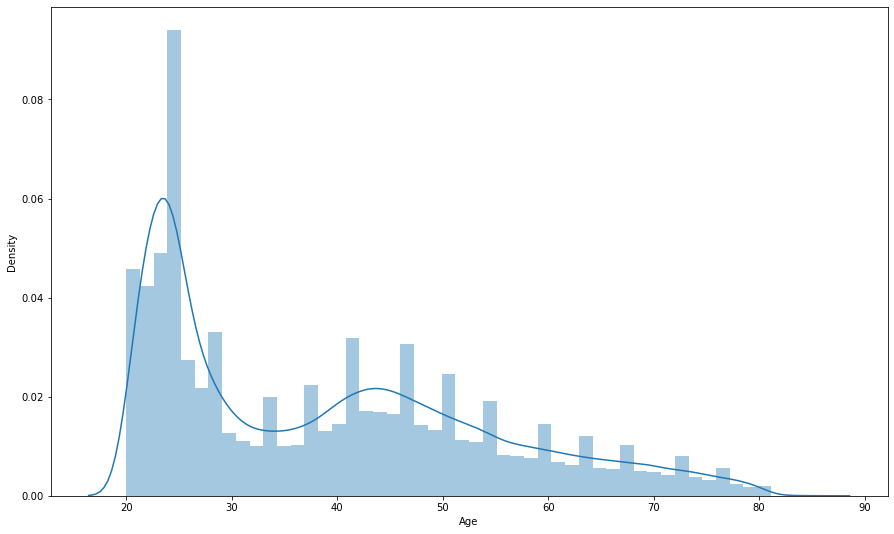

In [5]:
fig, aax = plt.subplots( figsize = (15,9))
aax = sns.distplot(train.Age)
train.Age.describe()

* 年齡為右偏分佈

<font color=black size=5 face=雅黑>Age 與 Response</font>

Text(0.5, 1.0, 'Age and Response Correlation')

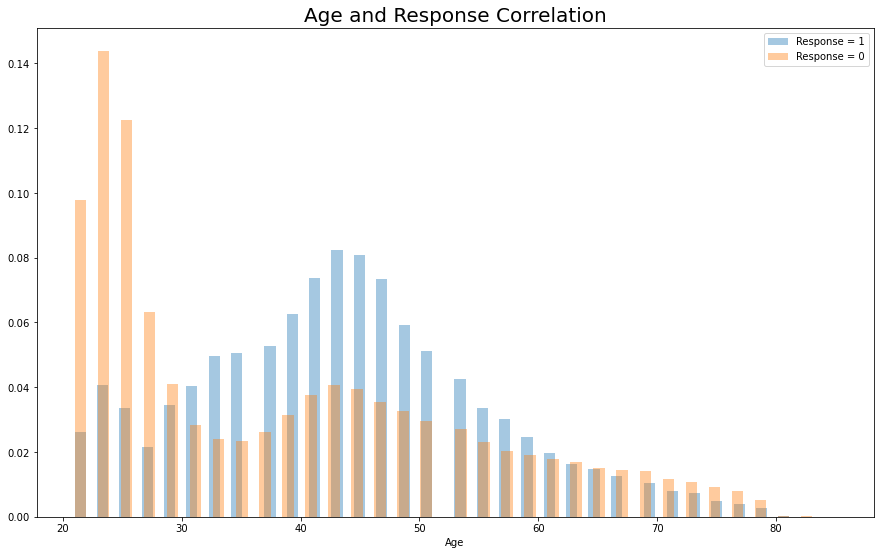

In [13]:
#年齡與意願，可以看到大概30歲~60歲，意願較強烈
Mask_Has_Age_P12_Survived = ((train.Age) & (train.Response == 1))
Mask_Has_Age_P12_Dead = ((train.Age) & (train.Response == 0))
fig, ax = plt.subplots( figsize = (15,9))
ax = sns.distplot(train.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=66,norm_hist=True,label='Response = 1')
ax = sns.distplot(train.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=66,norm_hist=True,label='Response = 0')

ax.legend()
ax.set_title('Age and Response Correlation',fontsize = 20)

* 年齡與意願關聯，可以看到大概30歲~60歲，意願較強烈

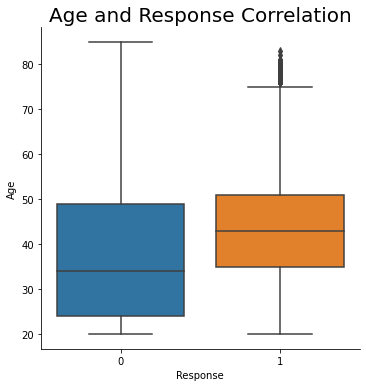

In [14]:
p=sns.catplot(x="Response",y="Age", data=train, kind='box')
plt.title("Age and Response Correlation", size=20, y=1.0);

<font color=black size=5 face=雅黑>Driving_License 與 Response</font>

Percentage of  Driving_License feature
 
1    99.786938
0     0.213062
Name: Driving_License, dtype: float64
   Driving_License  Response
0                0     0.050
1                1     0.123


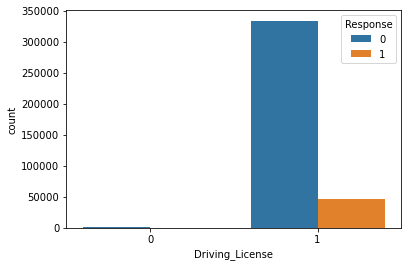

In [15]:
#擁有駕照對意願的作用不大，99%以上都有駕照
sns.countplot(train['Driving_License'], hue=train['Response'])

print("Percentage of  Driving_License feature\n ")
print(train['Driving_License'].value_counts()/len(train)*100)
print(train[["Driving_License", "Response"]].groupby(['Driving_License'], as_index=False).mean().round(3))

<font color=black size=5 face=雅黑>Region_code 與 Response</font>

Text(0.5, 1.0, 'Distribution of Region code')

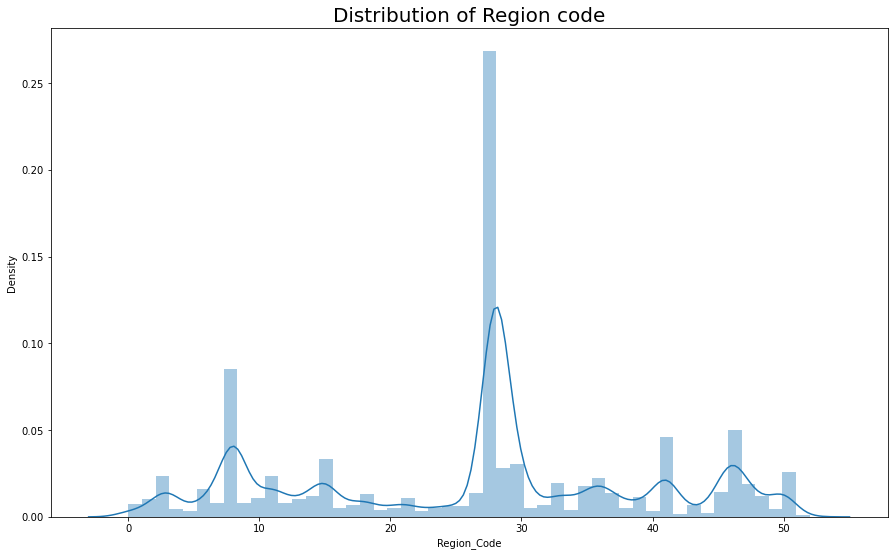

In [16]:
#地區分佈，我們可以看看哪個地區的意願最高

fig, aaax = plt.subplots( figsize = (15,9))
aaax = sns.distplot(train.Region_Code)
aaax.set_title('Distribution of Region code',fontsize = 20)

Text(0.5, 1.0, 'Region_Code and Response Correlation')

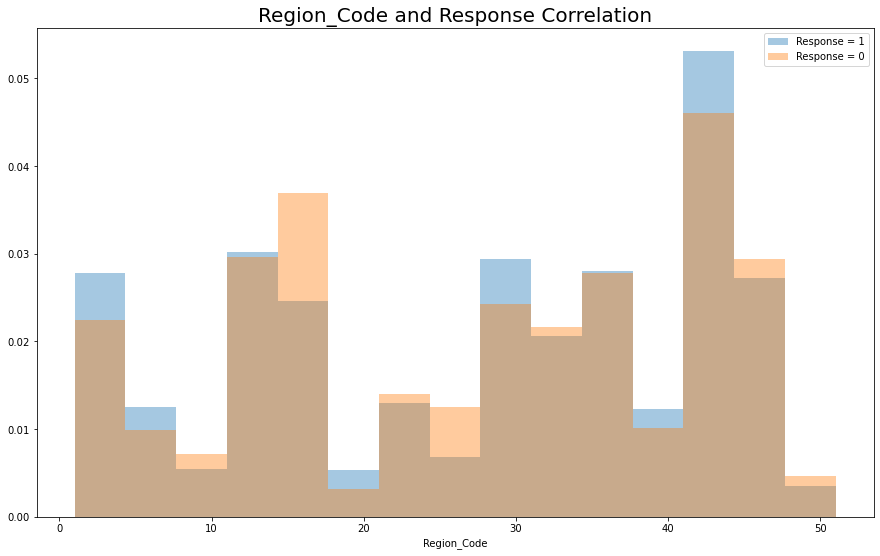

In [20]:
train[['Region_Code']] = train[['Region_Code']].astype(int)
test[['Region_Code']] = test[['Region_Code']].astype(int)

aa = ((train.Region_Code) & (train.Response == 1))
bb = ((train.Region_Code) & (train.Response == 0))
fig, ax = plt.subplots( figsize = (15,9))
ax = sns.distplot(train.loc[aa, 'Region_Code'],kde=False,bins=15,norm_hist=True,label='Response = 1')
ax = sns.distplot(train.loc[bb, 'Region_Code'],kde=False,bins=15,norm_hist=True,label='Response = 0')

ax.legend()
ax.set_title('Region_Code and Response Correlation',fontsize = 20)

* 觀察Region_Code，前五名的Response比例，高於後五名約10%

In [41]:
re_res = train.groupby(['Region_Code'], as_index=False)[['Age','Annual_Premium','Vintage','Response']].mean()
print(re_res.sort_values(by=['Response'], ascending = False).head(5))
print(re_res.sort_values(by=['Response'], ascending = False).tail(5))


    Region_Code        Age  Annual_Premium     Vintage  Response
38           38  44.861797    23395.500494  155.934353  0.192004
28           28  46.256853    38668.865245  154.396965  0.187163
19           19  42.585016    26575.475570  156.076221  0.162866
4             4  38.651860    23596.426430  155.247085  0.158245
23           23  38.671939    23275.169388  153.018878  0.153061
    Region_Code        Age  Annual_Premium     Vintage  Response
22           22  33.491215    24794.947288  156.158900  0.063407
50           50  37.785805    30955.099287  152.653227  0.062677
10           10  30.256516    25025.919753  154.877915  0.060128
25           25  30.667199    25689.397123  150.954055  0.042749
44           44  30.266089    24441.574257  159.569307  0.040842


<font color=black size=5 face=雅黑>Previously_Insured</font>

Percentage of Previously_Insured feature
 
0    54.178988
1    45.821012
Name: Previously_Insured, dtype: float64
   Previously_Insured  Response
0                   0     0.225
1                   1     0.001


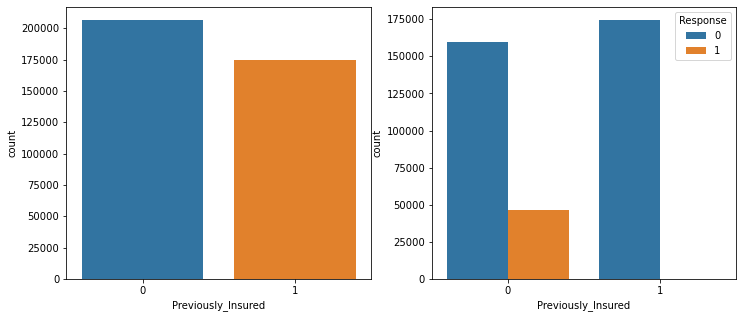

In [22]:
#投保歷史，Previously_Insured，比例相當，但先前沒有投保過的人有較強烈意願。
#可以透過購險經驗的分佈來看看

print("Percentage of Previously_Insured feature\n ")
print(train['Previously_Insured'].value_counts()/len(train)*100)
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
axx = ax.flatten()
sns.countplot(train['Previously_Insured'],ax = axx[0])
sns.countplot('Previously_Insured', hue = 'Response',ax =axx[1],data = train)

print(train[["Previously_Insured", "Response"]].groupby(['Previously_Insured'], as_index=False).mean().round(3))

* 年齡層較小的，Previously_Insured比例較高，所以也可以反應前面提到，為什麼年輕人較沒意願，因為他們大多數有投保歷史

Text(0.5, 1.0, 'Age and Previously_Insured Correlation')

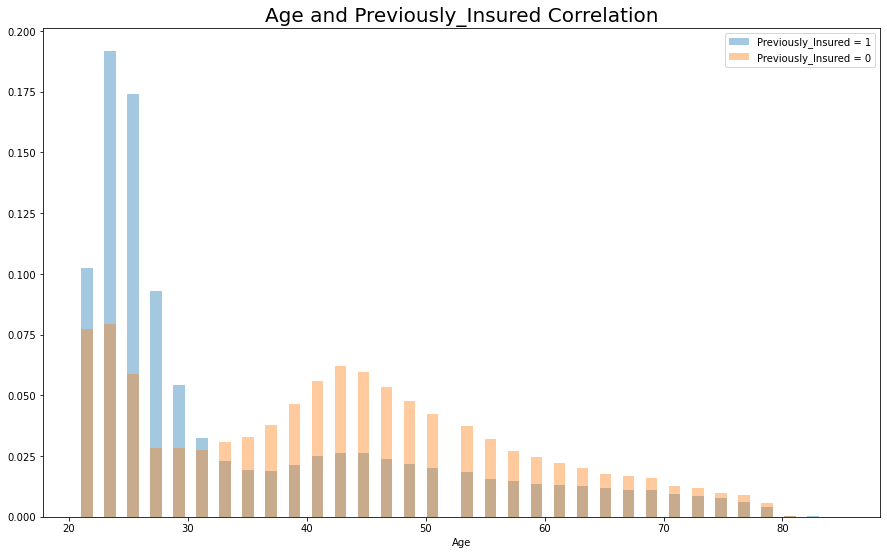

In [24]:
#Previously_Insured vs Age
aa = ((train.Age) & (train.Previously_Insured == 1))
bb = ((train.Age) & (train.Previously_Insured == 0))
fig, ax = plt.subplots( figsize = (15,9))
ax = sns.distplot(train.loc[aa, 'Age'],kde=False,bins=66,norm_hist=True,label='Previously_Insured = 1')
ax = sns.distplot(train.loc[bb, 'Age'],kde=False,bins=66,norm_hist=True,label='Previously_Insured = 0')

ax.legend()
ax.set_title('Age and Previously_Insured Correlation',fontsize = 20)

<font color=black size=5 face=雅黑>Vehicle_Age</font>

Percentage of vechicle age feature
 
1-2 Year     52.561341
< 1 Year     43.238549
> 2 Years     4.200111
Name: Vehicle_Age, dtype: float64
  Vehicle_Age  Response
0    1-2 Year     0.174
1    < 1 Year     0.044
2   > 2 Years     0.294


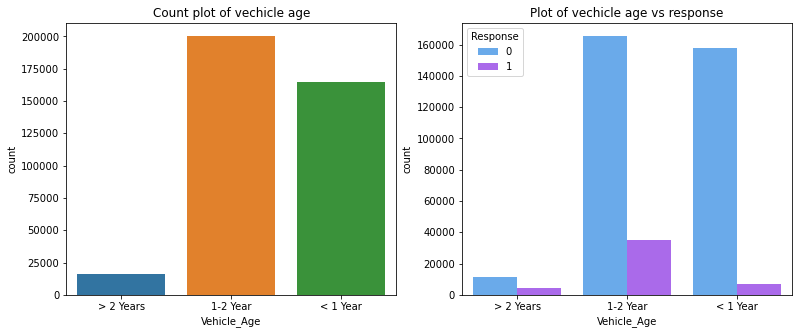

In [25]:
#大於兩年很少
#1~2年意願佔0.174，兩年以上佔0.294

print("Percentage of vechicle age feature\n ")
print(train['Vehicle_Age'].value_counts()/len(train)*100)

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sns.countplot(train['Vehicle_Age'])
plt.title("Count plot of vechicle age")
plt.subplot(1,2,2)
plt.title("Plot of vechicle age vs response")
sns.countplot('Vehicle_Age', hue = 'Response',data = train,palette="cool")

print(train[["Vehicle_Age", "Response"]].groupby(['Vehicle_Age'], as_index=False).mean().round(3))

In [26]:
#車齡特徵的平均年齡
final = train.groupby(['Vehicle_Age'], as_index=False)[['Age']].mean()
final

,Vehicle_Age,Age
0,1-2 Year,49.033537
1,< 1 Year,24.821878
2,> 2 Years,55.171862


<font color=black size=5 face=雅黑>Vehicle_Damage</font>

Percentage of vechicle damage feature
 
Yes    50.487656
No     49.512344
Name: Vehicle_Damage, dtype: float64
  Vehicle_Damage  Response
0             No     0.005
1            Yes     0.238


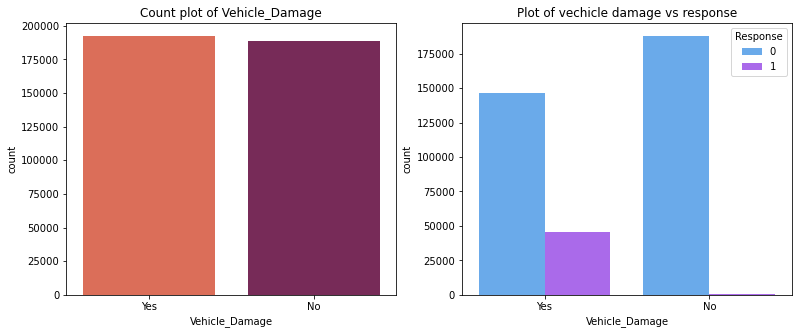

In [27]:
#有車損的人，意願較高，佔0.238%

print("Percentage of vechicle damage feature\n ")
print(train['Vehicle_Damage'].value_counts()/len(train)*100)
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sns.countplot(train['Vehicle_Damage'],palette="rocket_r")
plt.title("Count plot of Vehicle_Damage")
plt.subplot(1,2,2)
plt.title("Plot of vechicle damage vs response")
sns.countplot('Vehicle_Damage', hue = 'Response',data = train,palette="cool")

print(train[["Vehicle_Damage", "Response"]].groupby(['Vehicle_Damage'], as_index=False).mean().round(3))

<font color=black size=5 face=雅黑>Policy_Sales_Channel</font>

<AxesSubplot:xlabel='Policy_Sales_Channel', ylabel='Density'>

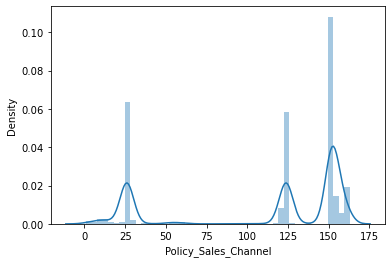

In [28]:
sns.distplot(train.Policy_Sales_Channel)

<font color=black size=5 face=雅黑>Annual_Premium</font>

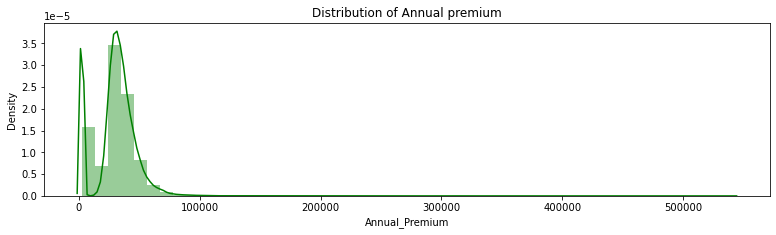

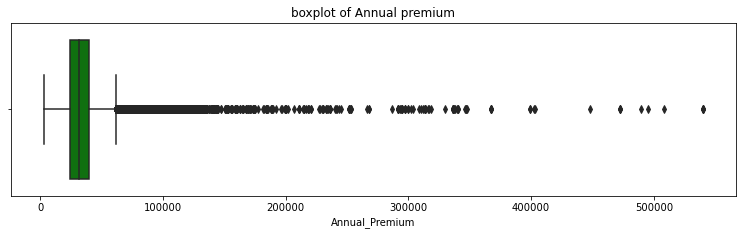

In [30]:
#年度保費
plt.figure(figsize=(13,7))
plt.subplot(2,1,1)
sns.distplot(train['Annual_Premium'], color='green')
plt.title("Distribution of Annual premium")
plt.show()
#print("-------------------------------------")
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sns.boxplot(train['Annual_Premium'],color='green')
plt.title("boxplot of Annual premium")
plt.show()

In [31]:
group_names = [1,2,3,4,5]

cats = pd.qcut(train['Annual_Premium'], 5, labels=group_names)

In [32]:
train['Annual_Premium_5'] = cats

* 將Annual_Premium分為五個階層，觀察與Response關係

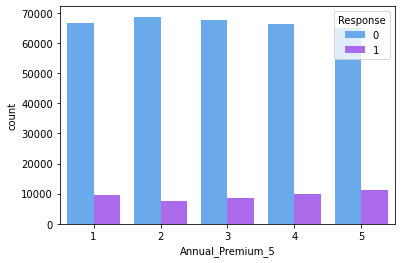

In [33]:
ax = sns.countplot('Annual_Premium_5',hue = 'Response',data = train,palette="cool")


* 將Annual_Premium分為五個階層，Previously_Insured關係

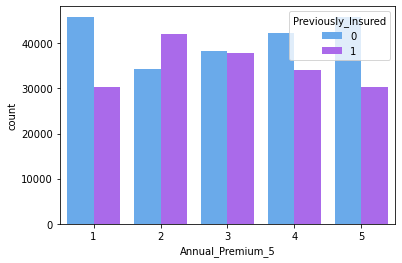

In [35]:
ax = sns.countplot('Annual_Premium_5',hue = 'Previously_Insured',data = train,palette="cool")

* 將Annual_Premium分為五個階層，與'Age','Annual_Premium','Response' 之統計意涵
* 年紀越大，年繳保費越多

In [37]:
aaa = train.groupby(['Annual_Premium_5'], as_index=False)[['Age']].mean()
bbb = train.groupby(['Annual_Premium_5'], as_index=False)[['Age']].median()

job_group = train.groupby(['Annual_Premium_5'])
print(job_group[['Age','Annual_Premium','Response']].aggregate(['min', 'max', 'mean', 'median']))
#年紀越大，年繳保費越多，直觀

                 Age                       Annual_Premium            \
                 min max       mean median            min       max   
Annual_Premium_5                                                      
1                 20  85  39.662998     38         2630.0   21583.0   
2                 20  85  34.729314     28        21584.0   29082.0   
3                 20  85  36.987076     32        29083.0   34406.0   
4                 20  85  39.413176     38        34407.0   41711.0   
5                 20  85  43.321071     44        41712.0  540165.0   

                                        Response                       
                          mean   median      min max      mean median  
Annual_Premium_5                                                       
1                  5129.989819   2630.0        0   1  0.123993      0  
2                 25980.204247  26238.0        0   1  0.099087      0  
3                 31692.742239  31669.0        0   1  0.112105      0  

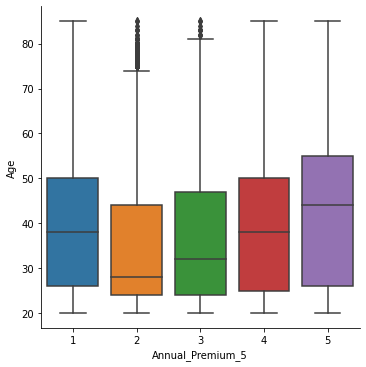

In [38]:
p=sns.catplot(x="Annual_Premium_5",y="Age", data=train, kind='box')


<AxesSubplot:xlabel='Vintage', ylabel='Density'>

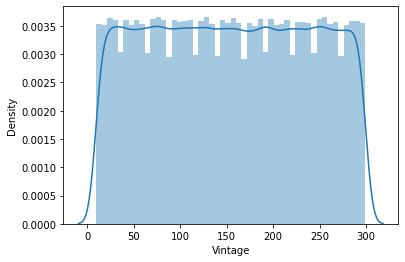

In [42]:
#Vintage，柱狀
sns.distplot(train.Vintage)


<font color=black size=5 face=雅黑>資料前處理</font>

In [7]:
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
test['Gender']=test['Gender'].replace({'Male':1,'Female':0})
train['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
test['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)
train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}, inplace=True)
test['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}, inplace=True)

train['Policy_Sales_Channel']=train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel']=test['Policy_Sales_Channel'].astype(int)

<AxesSubplot:title={'center':'Correlation plot'}>

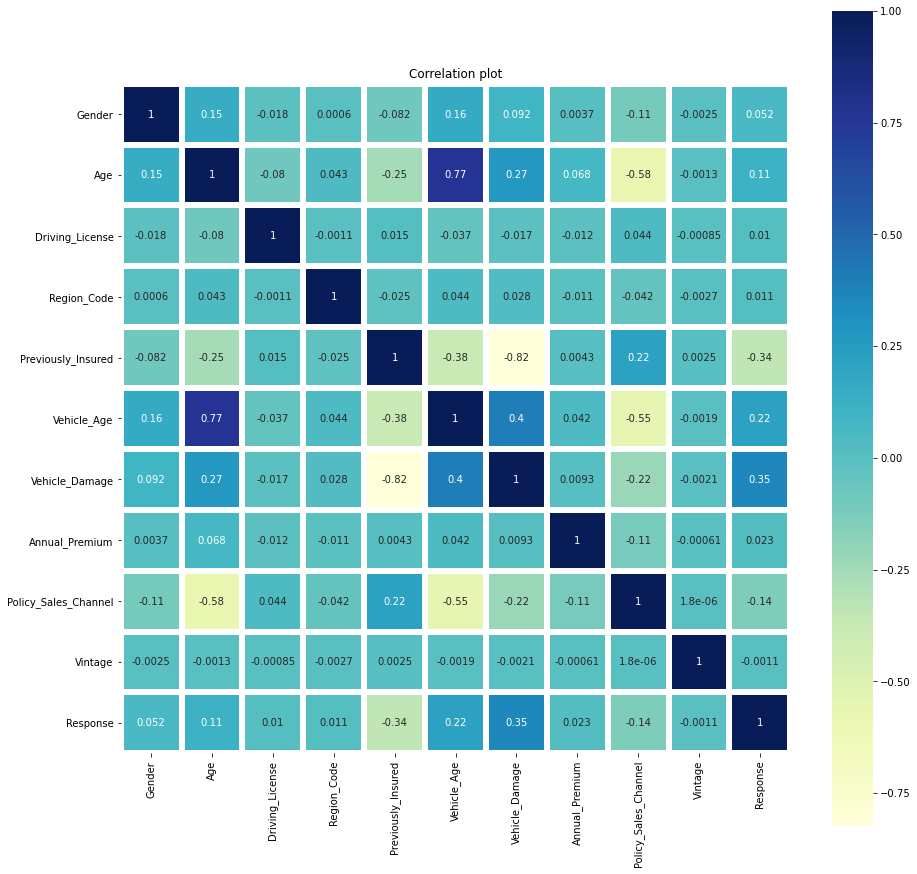

In [8]:
train_corr = train.drop(labels=['id'],axis=1)
plt.figure(figsize=(15,15))
plt.title("Correlation plot")
sns.heatmap(train_corr.corr(),linewidths=5, annot=True, square=True,annot_kws={'size': 10},cmap='YlGnBu')


EDA結果觀察
* 最重要的是 Response 與其他特徵的關係，看到 Response 和 Vehicle_Damage 之間存在一些相關性，而且與二進制 Previously_Insured 變量存在負相關。

另外還有一些特別的關係。
* 年輕人偏向買新車，會選擇他們喜歡的通路(例如網路)
* 年齡較大，意願較高，(因為他們沒有購買過，沒購買過的人意願也較高)
* 年齡成右偏分布，可能是一個新興保險市場。
* 車齡跟通路關係，其實是因為年齡跟通路，間接影響車齡

- 因Age為偏態，轉成常態分佈

In [11]:
transform_data = train['Age']
aa = QuantileTransformer(n_quantiles = 20,
                    random_state = 0,
                    output_distribution = 'normal'
                    ).fit_transform(transform_data.values.reshape(-1,1))

train['log_age'] = aa

transform_data = test['Age']
bb = QuantileTransformer(n_quantiles = 20,
                    random_state = 0,
                    output_distribution = 'normal'
                    ).fit_transform(transform_data.values.reshape(-1,1))

test['log_age'] = bb

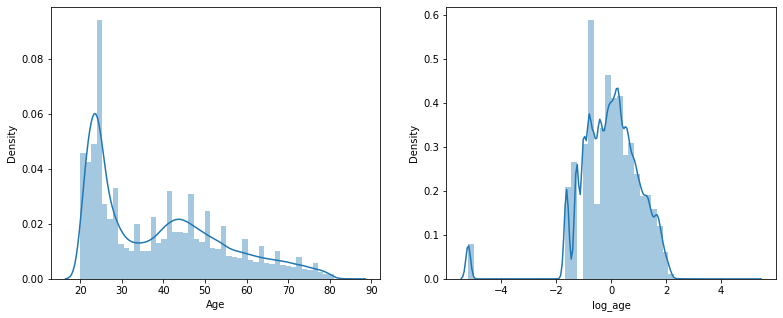

In [14]:
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sns.distplot(train.Age)
plt.subplot(1,2,2)
aax = sns.distplot(train.log_age)

<font color=black size=5 face=雅黑>資料縮放</font>

In [15]:
numeric_cols=['Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']
scaler=MinMaxScaler()
scaler.fit(train[numeric_cols])
scaler.fit(test[numeric_cols])

train[numeric_cols]=scaler.transform(train[numeric_cols])
test[numeric_cols]=scaler.transform(test[numeric_cols])

train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,log_age
0,1,1,44,1,0.538462,0,2,1,0.080577,0.154321,0.716263,1,0.336038
1,2,1,76,1,0.057692,0,1,0,0.065840,0.154321,0.598616,0,1.886627
2,3,1,47,1,0.538462,0,2,1,0.075976,0.154321,0.058824,1,0.529453
3,4,1,21,1,0.211538,1,0,0,0.055365,0.932099,0.667820,0,-1.619856
4,5,0,29,1,0.788462,1,0,0,0.052973,0.932099,0.100346,0,-0.266994


<font color=black size=5 face=雅黑>特徵工程</font>
* 在特徵篩選時，發現Driving_License並不重要，所以刪除
* 在EDA時，發現沒有車損的客戶，意願只占0.005，反之高達0.238
* 發現沒有車險的客戶，意願達0.225
* 將兩個特徵結合，有意願客戶聚集在沒有保單，且有發生車損
* 加入Damage_Pre，有效提升模型預測效能

In [16]:
train.loc[(train['Vehicle_Damage'] == 1) & (train['Previously_Insured'] == 1) ,'Damage_Pre']='1' #有車損，有保險
train.loc[(train['Vehicle_Damage'] == 1) & (train['Previously_Insured'] == 0) ,'Damage_Pre']='2' #有車損，沒保險
train.loc[(train['Vehicle_Damage'] == 0) & (train['Previously_Insured'] == 1) ,'Damage_Pre']='1' #沒車損，有保險
train.loc[(train['Vehicle_Damage'] == 0) & (train['Previously_Insured'] == 0) ,'Damage_Pre']='4' #沒車損，沒保險


test.loc[(test['Vehicle_Damage'] == 1) & (test['Previously_Insured'] == 1) ,'Damage_Pre']='1' #有車損，有保險
test.loc[(test['Vehicle_Damage'] == 1) & (test['Previously_Insured'] == 0) ,'Damage_Pre']='2' #有車損，沒保險
test.loc[(test['Vehicle_Damage'] == 0) & (test['Previously_Insured'] == 1) ,'Damage_Pre']='1' #沒車損，有保險
test.loc[(test['Vehicle_Damage'] == 0) & (test['Previously_Insured'] == 0) ,'Damage_Pre']='4' #沒車損，沒保險

<AxesSubplot:xlabel='Damage_Pre', ylabel='count'>

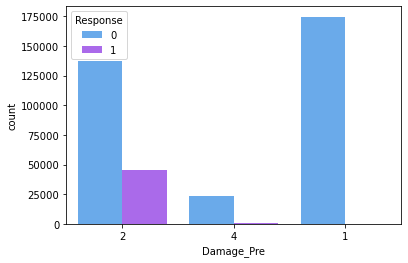

In [18]:
sns.countplot('Damage_Pre',hue = 'Response',data = train,palette="cool")

In [19]:
X = train.drop(labels=['id','Age','Driving_License','Previously_Insured','Vehicle_Damage','Response'],axis=1)
y = train.loc[:,'Response']
test = test.drop(labels=['id','Age','Previously_Insured','Vehicle_Damage','Driving_License'],axis=1)

'''數據拆成訓練測試'''
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)

'''RF'''
model = RandomForestClassifier(n_jobs=-1, random_state=42,oob_score=True)

clf = model.fit(x_train,y_train)

train_roc = roc_auc_score(y_train,clf.predict(x_train))
val_roc = roc_auc_score(y_val,clf.predict_proba(x_val)[:,1])

In [24]:
print("train_roc: ",train_roc)
print("val_roc: ",val_roc)

train_roc:  0.9994778621860646
val_roc:  0.836432629292718


In [23]:
feat_labels = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
threshold = 0.05
threshold_list = []
print("特徵重要程度")
for i in range(x_train.shape[1]):
    print("%2d) %-*s %f " % (i+1, 30, feat_labels[i], importances[i]))
    if importances[i] > threshold:
        threshold_list.append(feat_labels[i])
print(threshold_list)

特徵重要程度
 1) Gender                         0.009603 
 2) Region_Code                    0.105222 
 3) Vehicle_Age                    0.026236 
 4) Annual_Premium                 0.249930 
 5) Policy_Sales_Channel           0.069371 
 6) Vintage                        0.279247 
 7) log_age                        0.147054 
 8) Damage_Pre                     0.113336 
['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'log_age', 'Damage_Pre']


<font color=black size=5 face=雅黑>提交成績</font>

In [ ]:
y_pred = clf.predict_proba(test)[:,1]
sub = pd.DataFrame(y_pred,columns = ['Response'],index = [i + 381110 for i in range(test.shape[0])])
sub.index.name = 'id'
sub.to_csv('submit.csv')